In [1]:
# Packages importieren
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay,precision_recall_curve, roc_curve, auc, make_scorer
import pickle
import joblib

In [3]:
# Daten importieren
X_train = pd.read_csv("../../Resampling/X_train.csv", index_col=0)
X_test = pd.read_csv("../../Resampling/X_test.csv", index_col=0)
X_val = pd.read_csv("../../Resampling/X_val.csv", index_col=0)

X_train_ros = pd.read_csv("../../Resampling/X_train_ros.csv", index_col=0)
X_test_ros = pd.read_csv("../../Resampling/X_test_ros.csv", index_col=0)
X_val_ros = pd.read_csv("../../Resampling/X_val_ros.csv", index_col=0)

X_train_stm = pd.read_csv("../../Resampling/X_train_stm.csv", index_col=0)
X_test_stm = pd.read_csv("../../Resampling/X_test_stm.csv", index_col=0)
X_val_stm = pd.read_csv("../../Resampling/X_val_stm.csv", index_col=0)

y_train = pd.read_csv("../../Resampling/y_train.csv", index_col=0)
y_train_ros = pd.read_csv("../../Resampling/y_train_ros.csv", index_col=0)
y_train_stm = pd.read_csv("../../Resampling/y_train_stm.csv", index_col=0)

y_test = pd.read_csv("../../Resampling/y_test.csv", index_col=0)
y_val = pd.read_csv("../../Resampling/y_val.csv", index_col=0)

print("Alle Datensätze wurden importiert.")

Alle Datensätze wurden importiert.


In [60]:
print("X_train:", X_train.shape)
print("X_val:  ", X_val.shape)
print("X_test:  ", X_test.shape)

print("X_train_ros:", X_train_ros.shape)
print("X_val_ros:", X_val_ros.shape)
print("X_test_ros:", X_test_ros.shape)

print("y_train:", y_train.shape)
print("y_train_ros:", y_train_ros.shape)

print("y_val:  ", y_val.shape)
print("y_test:  ", y_test.shape)

X_train: (163304, 21)
X_val:   (25368, 21)
X_test:   (50736, 21)
X_train_ros: (163304, 21)
X_val_ros: (25368, 21)
X_test_ros: (50736, 21)
y_train: (163304, 1)
y_train_ros: (163304, 1)
y_val:   (25368, 1)
y_test:   (50736, 1)


In [61]:
df = pd.concat([X_train_ros, y_train_ros], axis=1)
duplicates = df[df.duplicated(keep=False)]
print(f"Anzahl der neuen Duplikate: {len(duplicates)}")

Anzahl der neuen Duplikate: 70896


## E_MT_LR_1: Logistische Regression mit resampeltem Datensatz

In [4]:
# Hyperparameter-Searching mit GridSearch
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['elasticnet'],
    'l1_ratio': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
    'solver': ['saga'],
    'max_iter': [50, 100, 500, 800]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    LogisticRegression(random_state=42),
    param_grid,
    cv=cv,
    scoring="recall",
    n_jobs=-1
)
grid_search.fit(X_train_stm, np.ravel(y_train_stm))

print("Beste Params:", grid_search.best_params_)
print("Validation Score:", grid_search.best_score_)

Beste Params: {'C': 10, 'l1_ratio': 0.6, 'max_iter': 50, 'penalty': 'elasticnet', 'solver': 'saga'}
Validation Score: 0.7821859768815764


In [5]:
# Modellanpassung
model1 = LogisticRegression(C=10, penalty='elasticnet', l1_ratio=0.6, solver='saga', max_iter=50, random_state=42)
model1.fit(X_train_stm, np.ravel(y_train_stm))

,penalty,'elasticnet'
,dual,False
,tol,0.0001
,C,10
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'saga'
,max_iter,50
,multi_class,'deprecated'


In [6]:
# Validierung Modell 1
y_pred_m1 = model1.predict(X_val_stm)
y_proba_m1 = model1.predict_proba(X_val_stm)[:, 1]

roc_auc = roc_auc_score(np.ravel(y_val), y_proba_m1)

print(f"ROC AUC:   {roc_auc:.3f}\n")
print(classification_report(np.ravel(y_val), y_pred_m1))
print(confusion_matrix(np.ravel(y_val), y_pred_m1))

ROC AUC:   0.808

              precision    recall  f1-score   support

           0       0.94      0.74      0.83     21833
           1       0.31      0.72      0.43      3535

    accuracy                           0.74     25368
   macro avg       0.63      0.73      0.63     25368
weighted avg       0.85      0.74      0.78     25368

[[16239  5594]
 [  998  2537]]


In [7]:
# Modellperformancecheck mit Testset
y_pred_m1 = model1.predict(X_test_stm)
y_proba_m1 = model1.predict_proba(X_test_stm)[:, 1]

roc_auc = roc_auc_score(np.ravel(y_test), y_proba_m1)

print(f"ROC AUC:   {roc_auc:.3f}\n")
print(classification_report(np.ravel(y_test), y_pred_m1))
print(confusion_matrix(np.ravel(y_test), y_pred_m1))

ROC AUC:   0.806

              precision    recall  f1-score   support

           0       0.94      0.74      0.83     43667
           1       0.31      0.72      0.44      7069

    accuracy                           0.74     50736
   macro avg       0.63      0.73      0.63     50736
weighted avg       0.86      0.74      0.78     50736

[[32464 11203]
 [ 1963  5106]]


## E_MT_LR_2: Logistische Regression mit originärem Datensaz und angepasster Variable 'class_weight'

In [19]:
# Hyperparameter-Searching mit GridSearch
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['elasticnet'],
    'l1_ratio': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
    'solver': ['saga'],
    'max_iter': [50, 100, 500, 800],
    'class_weight': [{0:1, 1:2}, {0:1, 1:3}, {0:1,1:4}, 'balanced']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {"recall":make_scorer(recall_score, pos_label=1), "precision":make_scorer(precision_score, pos_label=1), "f1":make_scorer(f1_score, pos_label=1)}

grid_search = GridSearchCV(
    LogisticRegression(random_state=42),
    param_grid,
    cv=cv,
    scoring=scoring,
    refit="recall",
    n_jobs=-1
)
grid_search.fit(X_train, np.ravel(y_train))

print("Beste Params:", grid_search.best_params_)
print("Validation Score:", grid_search.best_score_)

Beste Params: {'C': 1, 'class_weight': 'balanced', 'l1_ratio': 0.7, 'max_iter': 50, 'penalty': 'elasticnet', 'solver': 'saga'}
Validation Score: 0.7562615814933762


In [77]:
# Modellanpassung 2
model2 = LogisticRegression(C=1, penalty='elasticnet', l1_ratio=0.7, solver='saga', max_iter=50, random_state=42, class_weight='balanced')
model2.fit(X_train, np.ravel(y_train))

,penalty,'elasticnet'
,dual,False
,tol,0.0001
,C,1
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'saga'
,max_iter,50
,multi_class,'deprecated'


In [78]:
# Validierung Modell
y_pred_m2 = model2.predict(X_val)
y_proba_m2 = model2.predict_proba(X_val)[:, 1]

roc_auc = roc_auc_score(np.ravel(y_val), y_proba_m2)

print(f"ROC AUC:   {roc_auc:.3f}\n")
print(classification_report(np.ravel(y_val), y_pred_m2))
print(confusion_matrix(np.ravel(y_val), y_pred_m2))

ROC AUC:   0.820

              precision    recall  f1-score   support

           0       0.95      0.73      0.83     21833
           1       0.31      0.75      0.44      3535

    accuracy                           0.74     25368
   macro avg       0.63      0.74      0.63     25368
weighted avg       0.86      0.74      0.77     25368

[[16016  5817]
 [  877  2658]]


In [79]:
# Modellperformancecheck mit Testset
y_pred_m2 = model2.predict(X_test)
y_proba_m2 = model2.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(np.ravel(y_test), y_proba_m2)

print(f"ROC AUC:   {roc_auc:.3f}\n")
print(classification_report(np.ravel(y_test), y_pred_m2))
print(confusion_matrix(np.ravel(y_test), y_pred_m2))

ROC AUC:   0.819

              precision    recall  f1-score   support

           0       0.95      0.74      0.83     43667
           1       0.31      0.75      0.44      7069

    accuracy                           0.74     50736
   macro avg       0.63      0.74      0.64     50736
weighted avg       0.86      0.74      0.77     50736

[[32110 11557]
 [ 1766  5303]]


## E_MT_LR_3 Logistiche Regression mit originärem Datensatz

In [22]:
# Hyperparameter-Searching mit GridSearch
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['elasticnet'],
    'l1_ratio': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
    'solver': ['saga'],
    'max_iter': [50, 100, 500, 800]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {"recall":make_scorer(recall_score, pos_label=1), "precision":make_scorer(precision_score, pos_label=1), "f1":make_scorer(f1_score, pos_label=1)}

grid_search = GridSearchCV(
    LogisticRegression(random_state=42),
    param_grid,
    cv=cv,
    scoring=scoring,
    refit="recall",
    n_jobs=-1
)
grid_search.fit(X_train, np.ravel(y_train))

print("Beste Params:", grid_search.best_params_)
print("Validation Score:", grid_search.best_score_)

Beste Params: {'C': 10, 'l1_ratio': 0.4, 'max_iter': 50, 'penalty': 'elasticnet', 'solver': 'saga'}
Validation Score: 0.15556408171566338


In [80]:
# Modellanpassung 3
model3 = LogisticRegression(C=10, penalty='elasticnet', l1_ratio=0.4, solver='saga', max_iter=50, random_state=42)
model3.fit(X_train, np.ravel(y_train))

,penalty,'elasticnet'
,dual,False
,tol,0.0001
,C,10
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'saga'
,max_iter,50
,multi_class,'deprecated'


In [81]:
# Validierung Modell
y_pred_m3 = model3.predict(X_val)
y_proba_m3 = model3.predict_proba(X_val)[:, 1]

roc_auc = roc_auc_score(np.ravel(y_val), y_proba_m3)

print(f"ROC AUC:   {roc_auc:.3f}\n")
print(classification_report(np.ravel(y_val), y_pred_m3))
print(confusion_matrix(np.ravel(y_val), y_pred_m3))

ROC AUC:   0.820

              precision    recall  f1-score   support

           0       0.88      0.98      0.92     21833
           1       0.53      0.15      0.24      3535

    accuracy                           0.86     25368
   macro avg       0.70      0.57      0.58     25368
weighted avg       0.83      0.86      0.83     25368

[[21347   486]
 [ 2996   539]]


In [82]:
# Modellperformancecheck mit Testset
y_pred_m3 = model3.predict(X_test)
y_proba_m3 = model3.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(np.ravel(y_test), y_proba_m3)

print(f"ROC AUC:   {roc_auc:.3f}\n")
print(classification_report(np.ravel(y_test), y_pred_m3))
print(confusion_matrix(np.ravel(y_test), y_pred_m3))

ROC AUC:   0.819

              precision    recall  f1-score   support

           0       0.88      0.98      0.92     43667
           1       0.52      0.15      0.24      7069

    accuracy                           0.86     50736
   macro avg       0.70      0.57      0.58     50736
weighted avg       0.83      0.86      0.83     50736

[[42664  1003]
 [ 5979  1090]]


## Weitere Hyperparametertuning E_MT_LR_2

In [71]:
# Hyperparameter-Tuning mit Random Search
param_grid3 = {
    'C': [0.5, 1, 10, 100, 1000],
    'penalty': ['elasticnet'],
    'l1_ratio': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
    'solver': ['saga'],
    'class_weight': [{0:0.8, 1:2}, {0:1, 1:3}, {0:1, 1:4}, {0:1, 1:6}, {0:1, 1:8},'balanced']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {"recall":make_scorer(recall_score, pos_label=1), "precision":make_scorer(precision_score, pos_label=1), "f1":make_scorer(f1_score, pos_label=1)}

grid_search3 = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=42),
    param_grid3,
    cv=cv,
    scoring=scoring,
    refit="recall",
    n_jobs=-1
)
grid_search3.fit(X_train, np.ravel(y_train))

print("Beste Params:", grid_search3.best_params_)
print("Validation Score:", grid_search3.best_score_)

Beste Params: {'C': 1000, 'class_weight': {0: 1, 1: 8}, 'l1_ratio': 0.9, 'penalty': 'elasticnet', 'solver': 'saga'}
Validation Score: 0.8659525375805476


C:\Users\haihu\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [4]:
# Modellanpassung
final_model4 = LogisticRegression(C=1000, penalty='elasticnet', l1_ratio=0.9, solver='saga', max_iter=35, random_state=42, class_weight={0:1, 1:8})
final_model4.fit(X_train, np.ravel(y_train))

C:\Users\haihu\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


,penalty,'elasticnet'
,dual,False
,tol,0.0001
,C,1000
,fit_intercept,True
,intercept_scaling,1
,class_weight,"{0: 1, 1: 8}"
,random_state,42
,solver,'saga'
,max_iter,35
,multi_class,'deprecated'


In [5]:
# Performanceüberprüfen
y_pred4 = final_model4.predict(X_val)
y_proba4 = final_model4.predict_proba(X_val)[:, 1]

print("Test AUC:", roc_auc_score(np.ravel(y_val), np.ravel(y_proba4)))

print(classification_report(np.ravel(y_val), np.ravel(y_pred4)))

print(confusion_matrix(np.ravel(y_val), np.ravel(y_pred4)))

Test AUC: 0.8195072717026268
              precision    recall  f1-score   support

           0       0.95      0.71      0.81     21833
           1       0.30      0.77      0.44      3535

    accuracy                           0.72     25368
   macro avg       0.63      0.74      0.63     25368
weighted avg       0.86      0.72      0.76     25368

[[15567  6266]
 [  808  2727]]


In [86]:
# Feinabstimmung der Gewichtung
param_grid4 = {
    'class_weight': [{0:0.75,1:7.5},{0:1,1:8},{0:0.8,1:8.5}]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {"recall":make_scorer(recall_score, pos_label=1), "precision":make_scorer(precision_score, pos_label=1), "f1":make_scorer(f1_score, pos_label=1)}

grid_search4 = GridSearchCV(
    LogisticRegression(C=1000, penalty='elasticnet', l1_ratio=0.9, solver='saga', max_iter=35, random_state=42),
    param_grid4,
    cv=cv,
    scoring=scoring,
    refit="recall",
    n_jobs=-1
)

grid_search4.fit(X_train, np.ravel(y_train))

print("Beste Params:", grid_search4.best_params_)
print("Validation Score:", grid_search4.best_score_)

Beste Params: {'class_weight': {0: 1, 1: 8}}
Validation Score: 0.8955506381806119


C:\Users\haihu\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [90]:
# Performanceüberprüfen
y_pred_final = final_model4.predict(X_test)
y_proba_final = final_model4.predict_proba(X_test)[:, 1]

print("Test AUC:", roc_auc_score(np.ravel(y_test), np.ravel(y_proba_final)))

print(classification_report(np.ravel(y_test), np.ravel(y_pred_final)))

print(confusion_matrix(np.ravel(y_test), np.ravel(y_pred_final)))

Test AUC: 0.8196751839999441
              precision    recall  f1-score   support

           0       0.95      0.72      0.82     43667
           1       0.31      0.78      0.44      7069

    accuracy                           0.72     50736
   macro avg       0.63      0.75      0.63     50736
weighted avg       0.86      0.72      0.76     50736

[[31245 12422]
 [ 1582  5487]]


In [91]:
#Thresholdtuning
thresholds = np.linspace(0, 1, 101)
results = []

for t in thresholds:
    y_pred_t = (y_proba_final >= t).astype(int)
    precision = precision_score(np.ravel(y_test), y_pred_t)
    recall = recall_score(np.ravel(y_test), y_pred_t)
    f1 = f1_score(np.ravel(y_test), y_pred_t)
    results.append((t, precision, recall, f1))

df = pd.DataFrame(results, columns=["threshold","precision","recall","f1"])
print(df.sort_values("f1", ascending=False).head())

    threshold  precision  recall      f1
60    0.60000    0.34789 0.67266 0.45860
63    0.63000    0.35957 0.63078 0.45804
62    0.62000    0.35498 0.64422 0.45773
61    0.61000    0.35068 0.65695 0.45727
64    0.64000    0.36285 0.61678 0.45690


C:\Users\haihu\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [92]:
best_threshold = 0.60000
y_pred_final = (y_proba_final >= best_threshold).astype(int)

print("Test AUC:", roc_auc_score(np.ravel(y_test), np.ravel(y_proba_final)))

print(classification_report(np.ravel(y_test), np.ravel(y_pred_final)))

print(confusion_matrix(np.ravel(y_test), np.ravel(y_pred_final)))

Test AUC: 0.8196751839999441
              precision    recall  f1-score   support

           0       0.94      0.80      0.86     43667
           1       0.35      0.67      0.46      7069

    accuracy                           0.78     50736
   macro avg       0.64      0.73      0.66     50736
weighted avg       0.86      0.78      0.80     50736

[[34754  8913]
 [ 2314  4755]]


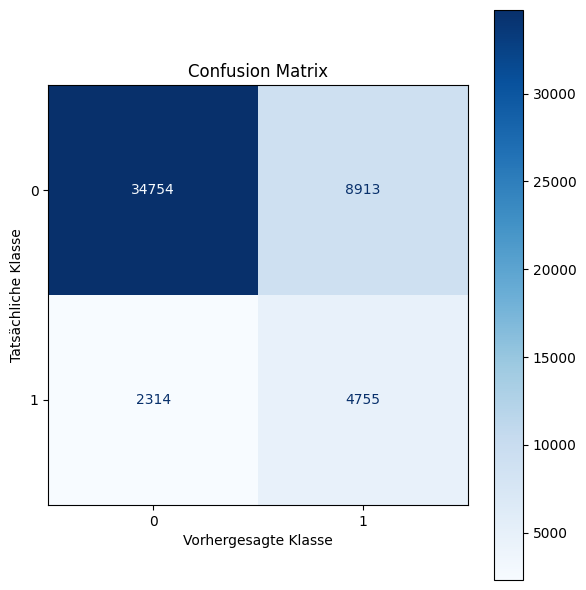

In [93]:
cm = confusion_matrix(y_test, y_pred_final)

labels = ["0", "1"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap='Blues', values_format='d')
ax.set_title("Confusion Matrix")
ax.set_xlabel("Vorhergesagte Klasse")
ax.set_ylabel("Tatsächliche Klasse")

plt.tight_layout()
plt.show()

In [6]:
# Finalmodell exportieren
joblib.dump(final_model4, 'logreg.pkl')

['logreg.pkl']